# Modelado

EXTRATEGIA QUE SE HA DECIDIDO SEGUIR:

## 1. Regresión Lineal

In [ ]:
# Separamos variable dependiente de las independientes
X = external.drop(columns=['Credit_Score', 'PROSPECTID'], inplace=False)
Y = external['Credit_Score']

# Generamos el dataset de entrenamiento y el de test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=29, shuffle=True)

### 6.1. OLS

Text(0.5, 1.0, 'Coeficientes del modelo')

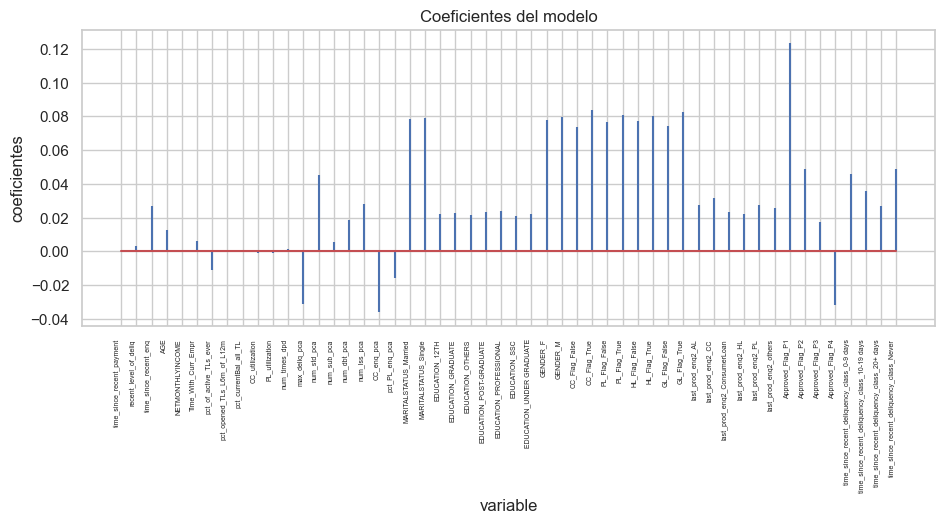

In [ ]:
OLS = LinearRegression(fit_intercept=False)
OLS.fit(X_train, y_train)

df_coeficientes = pd.DataFrame(
    {'Predictor': X_train.columns,
     'Coef': OLS.coef_.flatten()}
    )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.Predictor, df_coeficientes.Coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')

In [ ]:
y_pred = OLS.predict(X_test).flatten()
rmse_ols = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 0.028717252455970507


In [ ]:
def seleccionar_alpha_optimo(rmse_cv, rmse_sd, alphas):
    """ Selecciona el alpha óptimo usando la regla del mínimo + 1 desviación estándar. """
    min_rmse = np.min(rmse_cv)
    sd_min_rmse = rmse_sd[np.argmin(rmse_cv)]
    min_rmse_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
    optimo = alphas[np.argmin(rmse_cv)]
    optimo_1sd = alphas[rmse_cv == min_rmse_1sd][0]
    return optimo, optimo_1sd

### 6.2. Ridge

In [ ]:
modelo_ridge = RidgeCV(
    alphas=np.logspace(-3, 10, 200), 
    store_cv_values=True, 
    fit_intercept=False).fit(X_train, y_train)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


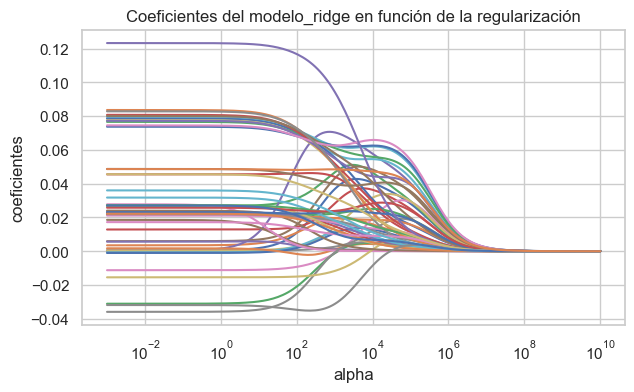

In [ ]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_ridge.alphas
coefs = []

for alpha in alphas:
    modelo_ridge_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_ridge_temp.fit(X_train, y_train)
    coefs.append(modelo_ridge_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo_ridge en función de la regularización')
plt.axis('tight')
plt.show()

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:110: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


Mejor valor de alpha encontrado: 0.6442363508721377
Mejor valor de alpha encontrado + 1 desviación estándar: 28005.038941836367


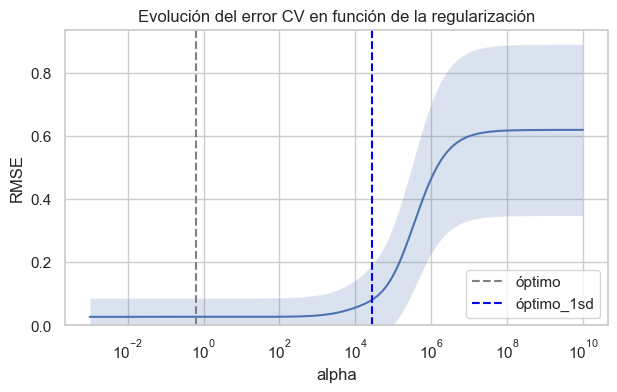

In [ ]:
mse_cv = modelo_ridge.cv_values_.mean(axis=0)
mse_sd = modelo_ridge.cv_values_.std(axis=0)
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)
optimo_ridge, optimo_ridge_1sd = seleccionar_alpha_optimo(rmse_cv, rmse_sd, modelo_ridge.alphas)

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo_ridge.alphas, rmse_cv)
ax.fill_between(
    modelo_ridge.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo_ridge,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_ridge_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()
print(f"Mejor valor de alpha encontrado: {modelo_ridge.alpha_}")
print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_ridge_1sd}")

In [ ]:
modelo_ridge_final = Ridge(alpha=optimo_ridge_1sd, fit_intercept=False).fit(X_train, y_train)
y_pred_ridge = modelo_ridge_final.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE Ridge: {rmse_ridge}")

RMSE Ridge: 0.082257425138576


Text(0.5, 1.0, 'Coeficientes del modelo_ridge_final')

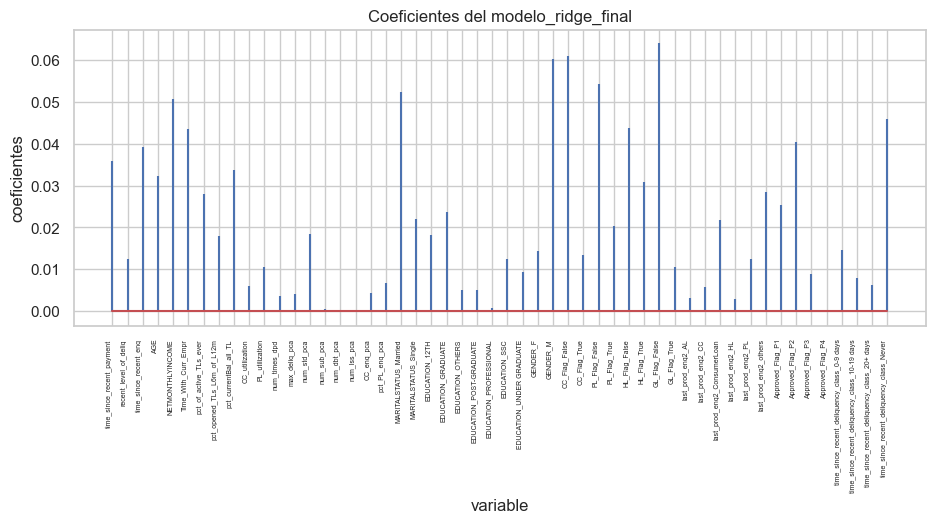

In [ ]:
# Coeficientes del modelo_ridge_final
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_ridge_final.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo_ridge_final')

### 6.3. Lasso

In [ ]:

modelo_lasso = LassoCV(
    alphas=np.logspace(-7, 3, 200), 
    cv=5,
    fit_intercept=False).fit(X_train, y_train)

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e+01, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(


C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e+00, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e+00, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8

Text(0.5, 1.0, 'Coeficientes del modelo_lasso en función de la regularización')

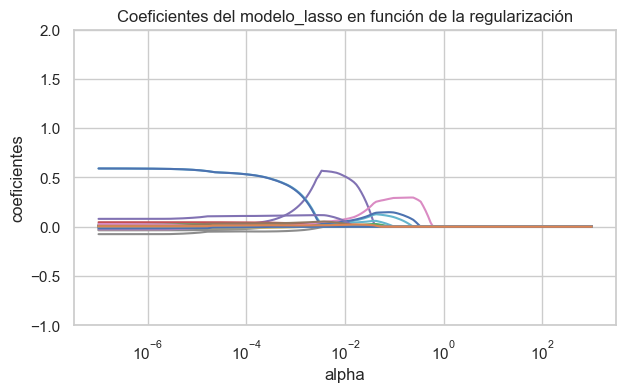

In [ ]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_lasso.alphas_
coefs = []

for alpha in alphas:
    modelo_lasso_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_lasso_temp.fit(X_train, y_train)
    coefs.append(modelo_lasso_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-1,2])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo_lasso en función de la regularización')

Mejor valor de alpha encontrado: 4.500557675700497e-07
Mejor valor de alpha encontrado + 1 desviación estándar: 0.0016638168860761307


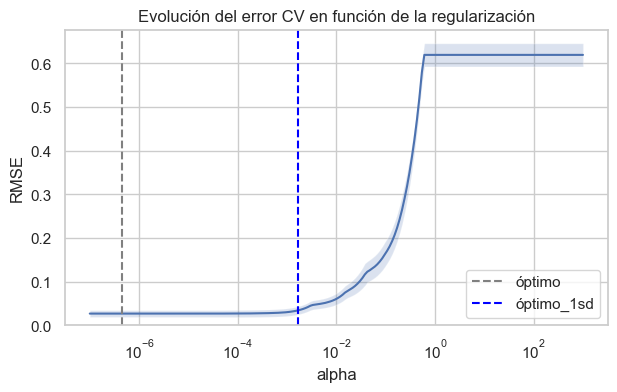

In [ ]:
mse_cv = modelo_lasso.mse_path_.mean(axis=1)
mse_sd = modelo_lasso.mse_path_.std(axis=1)
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)
optimo_lasso, optimo_lasso_1sd = seleccionar_alpha_optimo(rmse_cv, rmse_sd, modelo_lasso.alphas_)



# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo_lasso.alphas_, rmse_cv)
ax.fill_between(
    modelo_lasso.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo_lasso,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_lasso_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()
print(f"Mejor valor de alpha encontrado: {modelo_lasso.alpha_}")
print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_lasso_1sd}")

In [ ]:
modelo_lasso_final = Lasso(alpha=optimo_lasso_1sd, fit_intercept=False).fit(X_train, y_train)
y_pred_lasso = modelo_lasso_final.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE Lasso: {rmse_lasso}")

RMSE Lasso: 0.0359411229161743


In [ ]:
# Coeficientes del modelo_lasso_final
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_lasso_final.coef_.flatten()}
                  )

# Predictores incluidos en el modelo_lasso_final (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
2,time_since_recent_enq,0.035873
3,AGE,0.000626
4,NETMONTHLYINCOME,0.304600
5,Time_With_Curr_Empr,0.024843
8,pct_currentBal_all_TL,0.003798
13,num_std_pca,0.026416
19,MARITALSTATUS_Married,0.263638
20,MARITALSTATUS_Single,0.253851
29,GENDER_M,0.012144
30,CC_Flag_False,0.019649


Text(0.5, 1.0, 'Coeficientes del modelo')

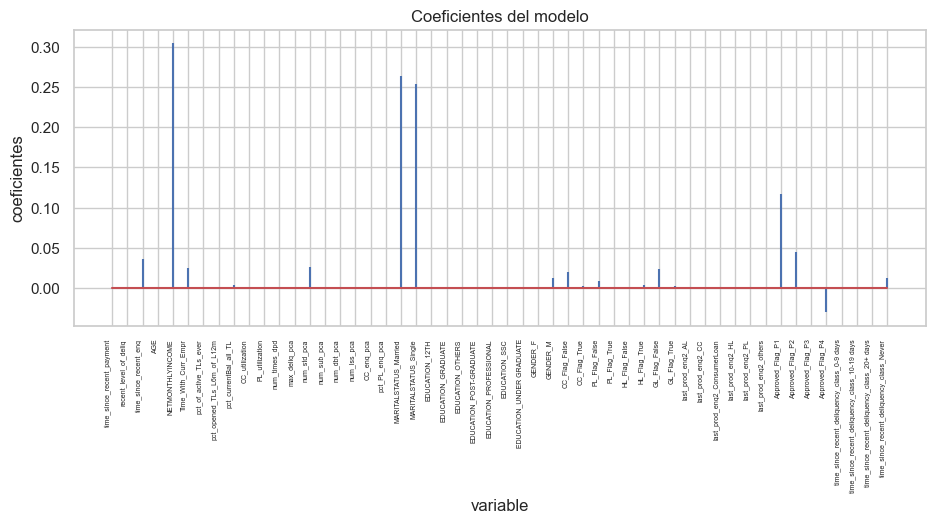

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')

### 6.4. Elastic Net

In [ ]:
# ElasticNetCV - Ajuste y selección de alpha óptimo
modelo_elastic = ElasticNetCV(
    l1_ratio=[0, 0.1, 0.4, 0.5, 0.7, 0.9, 0.99], 
    alphas=np.logspace(-8, 3, 200), 
    cv=5, 
    fit_intercept=False).fit(X_train, y_train)


C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6255.164790529075, tolerance: 1.2612243057692962
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWar

C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e+01, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e+01, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8

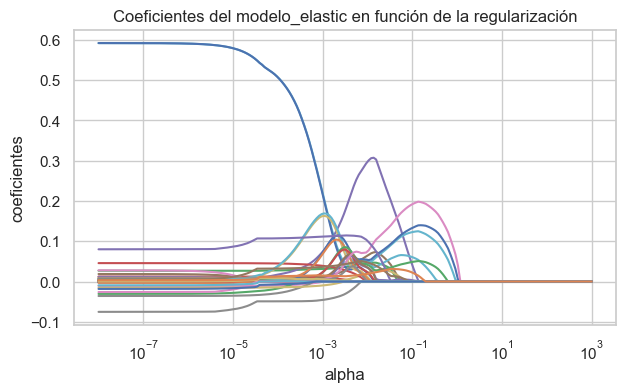

In [ ]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_elastic.alphas
coefs = []

for alpha in alphas:
    modelo_elastic_temp = ElasticNet(alpha=alpha, fit_intercept=False)
    modelo_elastic_temp.fit(X_train, y_train)
    coefs.append(modelo_elastic_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo_elastic en función de la regularización')
plt.axis('tight')
plt.show()

In [ ]:
mse_cv = modelo_elastic.mse_path_.mean(axis=2)
mse_sd = modelo_elastic.mse_path_.std(axis=2)
rmse_cv, rmse_sd = np.sqrt(mse_cv), np.sqrt(mse_sd)

best_l1_idx, best_alpha_idx = np.unravel_index(np.argmin(rmse_cv), rmse_cv.shape)
optimo_elastic, optimo_elastic_1sd = seleccionar_alpha_optimo(
    rmse_cv[best_l1_idx, :], rmse_sd[best_l1_idx, :], modelo_elastic.alphas_)

In [ ]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo_elastic.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo_elastic.l1_ratio, modelo_elastic.alphas_],
                                    names     = ['l1_ratio', 'modelo_elastic.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo_elastic.alphas_,mse_cv,rmse_cv
763,0.5,9.771242e-07,0.000720,0.026842
561,0.4,1.260383e-06,0.000720,0.026842
966,0.7,6.669920e-07,0.000720,0.026842
562,0.4,1.109752e-06,0.000720,0.026842
1168,0.9,5.170920e-07,0.000720,0.026842
...,...,...,...,...
649,0.5,1.956398e+00,0.383779,0.619499
650,0.5,1.722586e+00,0.383779,0.619499
651,0.5,1.516717e+00,0.383779,0.619499
652,0.5,1.335452e+00,0.383779,0.619499


In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo_elastic.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo_elastic.l1_ratio_}")

Mejor valor de alpha encontrado: 9.771241535346501e-07
Mejor valor de l1_ratio encontrado: 0.5


In [ ]:
modelo_elastic_final = ElasticNet(alpha=optimo_elastic_1sd, fit_intercept=False).fit(X_train, y_train)
y_pred_elastic = modelo_elastic_final.predict(X_test)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
print(f"RMSE Elastic Net: {rmse_elastic}")

RMSE Elastic Net: 0.03557631456930592


C:\Users\Ismael Laso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e+00, tolerance: 1.576e+00
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'rmse_cv')

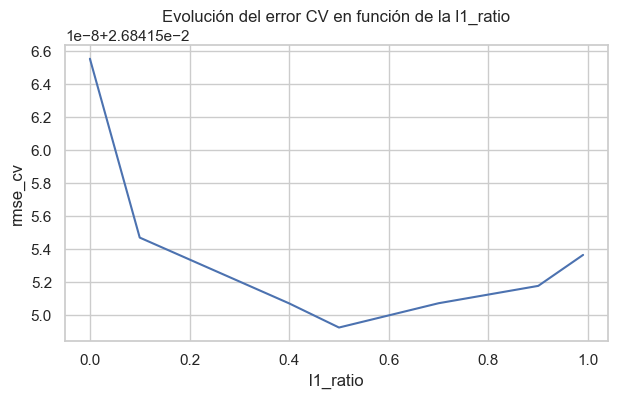

In [ ]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv')

In [ ]:
# Coeficientes del modelo_elastic_final
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_elastic_final.coef_.flatten()}
                  )
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,time_since_recent_payment,0.000068
2,time_since_recent_enq,0.037952
3,AGE,0.003084
4,NETMONTHLYINCOME,0.201540
5,Time_With_Curr_Empr,0.033360
8,pct_currentBal_all_TL,0.006162
13,num_std_pca,0.024936
19,MARITALSTATUS_Married,0.040858
20,MARITALSTATUS_Single,0.029894
28,GENDER_F,0.046195


Text(0.5, 1.0, 'Coeficientes del modelo')

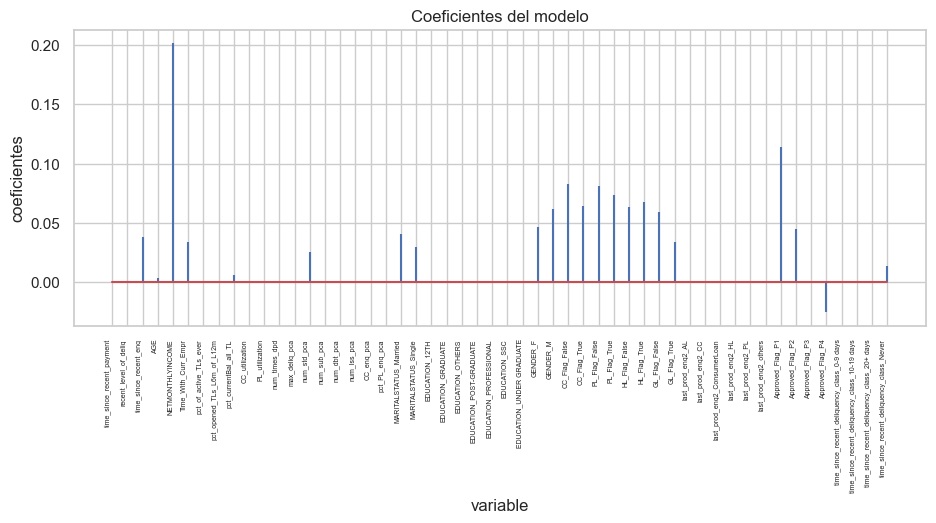

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')

### 6.5. Comparación

Text(0.5, 1.0, 'Comparación de modelos')

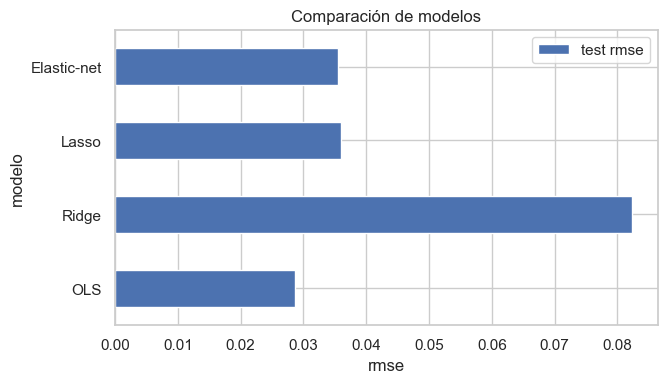

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos')